In [1]:
from tqdm import tqdm 

import os
import gc
from time import sleep

import numpy as np

import torch

from unet import Unet
from scheduler import get_schedules

In [2]:
torch.manual_seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
n_T = 1000
betas = [1e-4, 0.02]

In [4]:
if not os.path.isdir('results'):
    os.makedirs('results')

In [5]:
unet = Unet(n_features=128).to(device)

# pre-compute schedules
schedules = get_schedules(betas[0], betas[1], n_T)
schedules = {key: val.to(device) for key, val in schedules.items()}  # add all tensors on device

In [6]:
loaded_state_dict = torch.load(f"saved_models/unet_mnist.pt", map_location=torch.device(device))
unet.load_state_dict(loaded_state_dict)
unet.eval()


Unet(
  (encoder): Encoder(
    (initial_features): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GroupNorm(8, 128, eps=1e-05, affine=True)
            (2): ReLU()
          )
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (down2): UnetDown(
      (model): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GroupNorm(8, 256, eps=1e-05, affine=True)
            (2): ReLU()
          )
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [7]:
def sample(model, n_T, n_samples, sample_shape, device, schedules):

    # Step 1
    x_T = torch.randn(n_samples, *sample_shape).to(device)
    ones = torch.ones(n_samples).to(device)

    # Step 2
    x_i = x_T
    for i in tqdm(range(n_T, 0, -1)):
        # Step 3
        z = torch.randn(n_samples, *sample_shape).to(device) if i > 1 else 0
        # Step 4
        t = (i / n_T)*ones
        eps = model(x_i, t)

        # Very important: use eps.clone().detach() to avoid Out-of-memory errors
        # If eps stays connected to the computational graph, x_i will be connected to all  
        # the tensors produced by the model
        eps = eps.clone().detach()  
        v = schedules["one_over_sqrt_a"][i] * (x_i - eps * schedules["inv_alpha_over_sqrt_inv_abar"][i])
        x_i = v + schedules["sqrt_beta"][i] * z


    # Step 6
    x = x_i
    return x

    

100%|██████████| 1000/1000 [00:05<00:00, 189.68it/s]


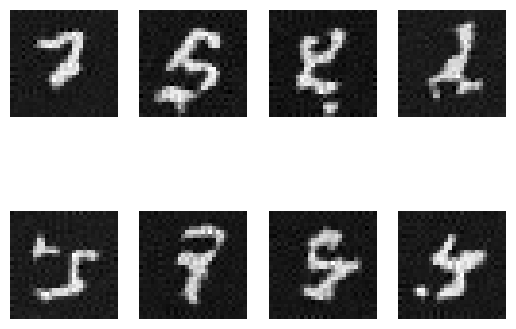

In [8]:
n_samples = 8

x_hat = sample(unet, n_T, n_samples, (1, 28, 28), device, schedules)
x_hat = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

import matplotlib.pyplot as plt

for i, img in enumerate(x_hat):
    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.draw()